#### クラス編成
- 課題整理(条件)
  - 全生徒を1つのクラスに割り当てる
  - クラス人数は39人以上40人以下
  - 男子生徒、女子生徒は20人以下
  - 学力試験のクラス平均点は学年平均の±10点
  - リーダ気質の生徒を2人以上
  - 特別支援生徒は1人以下
  - 特定ペアの生徒は別クラスとする

- List
  - $S$ : Students list
  - $C$ : Class list
  - $S_{male}$ : Men list
  - $S_{female}$ : Women list
  - $S_{leader}$ : leaders list
  - $S_{support}$ : supports list
  - $S_{specific}$ : Specific Pairs list
- Variable
  - $x_{s,c} \in \{0, 1\} (s\in S, c\in C)$
- Constant
  - $score_s$ : Score of students
  - $score_{mean}$ : Score of mean
- Constraints
  1. $\sum_{c\in C} x_{s,c} = 1 \quad (s \in S)$
  2. $\sum_{s\in S} x_{s,c} \ge 39 \quad (c \in C), \quad \sum_{s\in S} x_{s,c} \le 40 \quad (c \in C)$
  3. $\sum_{s\in S_{male}} x_{s,c} \le 20 \quad (c \in C), \quad \sum_{s\in S_{female}} x_{s,c} \le 20 \quad (c \in C)$
  4. $\sum_{S_{leader}}x_{s,c} \le 2$
  5. $\sum_{S_{support}}x_{s,c} \le 1$
  6. $(score_{mean}-10) \cdot \sum_{s\in S} x_{s,c} \ge \sum_{s\in S} score_s \cdot x_{s,c}, \quad \sum_{s\in S} score_s \cdot x_{s,c} \le (score_{mean}+10) \cdot \sum_{s\in S} x_{s,c}$
  7. $x_{s1,c} + x_{s2,c} \le 1$
- Objective
  - None(Maximize)

In [1]:
from pulp import LpProblem, LpVariable, LpMaximize, LpStatus, lpSum, value
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import math
import time

In [2]:
print(glob('../*/*school/*.csv'))

students_df = pd.read_csv(glob('../*/*school/students.csv')[0])
pairs_df = pd.read_csv(glob('../*/*school/student_pairs.csv')[0])

display(students_df.head(3))
display(pairs_df)

['..\\PyOptBook-main\\3.school\\students.csv', '..\\PyOptBook-main\\3.school\\student_pairs.csv']


,student_id,gender,leader_flag,support_flag,score
0,1,0,0,0,335
1,2,1,0,0,379
2,3,0,0,0,350


,student_id1,student_id2
0,118,189
1,72,50
2,314,233


In [3]:
# initial value
student_num = students_df['student_id'].count()
max_in_class = 40
class_num = math.ceil(student_num / max_in_class)
class_dict = {i:chr(i+65) for i in range(class_num)}

# rank, init_class を追加
students_df2 = students_df.copy()
students_df2.columns = ['id', 'gender', 'leader', 'support', 'score']

students_df2['rank'] = students_df2['score'].rank(ascending=False, method='first')
students_df2['init_class'] = students_df2['rank'].map(lambda x: x % 8).map(class_dict)

students_df2.head(3)

,id,gender,leader,support,score,rank,init_class
0,1,0,0,0,335,109.0,F
1,2,1,0,0,379,38.0,G
2,3,0,0,0,350,79.0,H


In [4]:
# 変数作成のため、仮クラスを作成
s_df = pd.DataFrame()
for i in range(class_num):
    tmp_df = students_df2.copy()
    tmp_df['class'] = chr(i+65)
    s_df = pd.concat([s_df, tmp_df])

# init_class == class -> True
s_df['flag'] = s_df['init_class'] == s_df['class']
print(s_df.shape)
display(s_df.head(3))

(2544, 9)


,id,gender,leader,support,score,rank,init_class,class,flag
0,1,0,0,0,335,109.0,F,A,False
1,2,1,0,0,379,38.0,G,A,False
2,3,0,0,0,350,79.0,H,A,False


In [5]:
# variable
s_df['variable'] = [LpVariable(f'x{id:03}{c}', cat='Binary') for id, c in zip(s_df['id'], s_df['class'])]

# variable * score, flag
s_df['score*var'] = s_df['variable'] * s_df['score']
s_df['flag*var'] = s_df['variable'] * s_df['flag']

print(s_df.shape)
s_df.head(3)

(2544, 12)


,id,gender,leader,support,score,rank,init_class,class,flag,variable,score*var,flag*var
0,1,0,0,0,335,109.0,F,A,False,x001A,{x001A: 335},{}
1,2,1,0,0,379,38.0,G,A,False,x002A,{x002A: 379},{}
2,3,0,0,0,350,79.0,H,A,False,x003A,{x003A: 350},{}


数理モデル定義

In [6]:
s_df['flag*var'][s_df['flag*var']!={}]

22     {x023A: 1}
55     {x056A: 1}
67     {x068A: 1}
81     {x082A: 1}
88     {x089A: 1}
          ...    
280    {x281H: 1}
283    {x284H: 1}
300    {x301H: 1}
313    {x314H: 1}
316    {x317H: 1}
Name: flag*var, Length: 318, dtype: object

In [7]:
np.random.seed(1)
problem = LpProblem('ClassAssignmentProblemByPandas', LpMaximize)

# init_class 最大化(元のクラスを維持)
problem += lpSum(s_df['flag*var'][s_df['flag*var']!={}])

for k, v in s_df.groupby('id'):
    # 全生徒を振り分け
    problem += lpSum(v['variable']) == 1

for k, v in s_df.groupby('class'):
    # クラス人数
    problem += lpSum(v['variable']) >= 39
    problem += lpSum(v['variable']) <= 40
    # 男女最大値
    problem += lpSum(v['variable'][v['gender'] == 1]) <= 20
    problem += lpSum(v['variable'][v['gender'] == 0]) <= 20
    # リーダー数
    problem += lpSum(v['variable'][v['leader'] == 1]) >= 2
    # サポート数
    problem += lpSum(v['variable'][v['support'] == 1]) <= 1
    # 平均点±10以内
    problem += (students_df['score'].mean() - 10) * lpSum(v['variable']) <= lpSum(v['score*var'])
    problem += (students_df['score'].mean() + 10) * lpSum(v['variable']) >= lpSum(v['score*var'])

# 特定メンバーは異なるクラス
for i, s1, s2 in pairs_df.itertuples():
    for k, v in s_df.groupby(['class']):
        problem += lpSum([v['variable'][v['id'] == s1], v['variable'][v['id'] == s2]]) <= 1

# problem

In [8]:
time_start = time.time()
status = problem.solve()
time_stop = time.time()

print('Status:', LpStatus[status])
print(f'Calculating Time: {time_stop - time_start:.3f} (sec)')

Status: Optimal
Calculating Time: 0.275 (sec)


In [9]:
s_df['result'] = s_df['variable'].apply(value)
result_df = s_df[s_df['result'] == 1]
result_df = result_df.sort_values('id').reset_index(drop=True)

student_by_class = {}
for c in result_df['class'].sort_values().unique():
    student_by_class[c] = result_df['id'][result_df['class'] == c].to_list()

for c, Ss in student_by_class.items():
    # print(f'Class: {c}')
    # print(f'Num: {len(Ss)}')
    print(f'id: {Ss}')
    # print('*' * 5)

id: [56, 68, 82, 89, 102, 106, 113, 115, 117, 123, 124, 127, 140, 172, 173, 175, 185, 186, 204, 210, 228, 255, 274, 277, 280, 285, 288, 289, 292, 293, 295, 297, 298, 304, 308, 311, 313, 316, 318]
id: [14, 17, 27, 30, 32, 35, 41, 49, 64, 66, 79, 83, 86, 97, 114, 119, 122, 132, 134, 141, 149, 151, 157, 158, 165, 178, 190, 198, 200, 209, 212, 213, 226, 237, 272, 296, 303, 306, 307, 309]
id: [21, 38, 44, 46, 51, 54, 62, 63, 73, 75, 76, 84, 85, 88, 99, 120, 138, 142, 143, 144, 150, 166, 183, 192, 193, 195, 201, 205, 207, 211, 217, 221, 222, 243, 244, 263, 264, 287, 299, 315]
id: [5, 11, 23, 24, 39, 47, 50, 61, 67, 74, 90, 92, 93, 100, 104, 109, 116, 121, 131, 136, 147, 152, 155, 167, 170, 176, 196, 199, 218, 219, 227, 230, 231, 236, 239, 253, 257, 259, 271, 294]
id: [4, 8, 12, 13, 19, 22, 33, 43, 48, 55, 57, 59, 98, 112, 125, 130, 133, 139, 153, 169, 177, 184, 189, 203, 234, 235, 240, 241, 249, 251, 254, 256, 261, 266, 268, 276, 283, 291, 302]
id: [1, 6, 16, 28, 29, 40, 42, 45, 58, 70, 77, 

In [10]:
# クラス人数確認
result_df.groupby(['class'])['id'].count()

class
A    39
B    40
C    40
D    40
E    39
F    40
G    40
H    40
Name: id, dtype: int64

In [11]:
# 男女人数確認
result_df.groupby(['class', 'gender'])['id'].count()

class  gender
A      0         20
       1         19
B      0         20
       1         20
C      0         20
       1         20
D      0         20
       1         20
E      0         20
       1         19
F      0         20
       1         20
G      0         20
       1         20
H      0         20
       1         20
Name: id, dtype: int64

In [12]:
# リーダー人数確認
result_df.groupby(['class', 'leader'])['id'].count()

class  leader
A      0         37
       1          2
B      0         38
       1          2
C      0         38
       1          2
D      0         38
       1          2
E      0         37
       1          2
F      0         37
       1          3
G      0         38
       1          2
H      0         38
       1          2
Name: id, dtype: int64

In [13]:
# サポート人数確認
result_df.groupby(['class', 'support'])['id'].count()

class  support
A      0          38
       1           1
B      0          39
       1           1
C      0          39
       1           1
D      0          40
E      0          39
F      0          40
G      0          39
       1           1
H      0          40
Name: id, dtype: int64

In [14]:
# 特定メンバー重複確認
for i, s1, s2 in pairs_df.itertuples():
    print(result_df[['id', 'class']][result_df['id'] == s1].values, result_df[['id', 'class']][result_df['id'] == s2].values)

[[118 'F']] [[189 'E']]
[[72 'H']] [[50 'D']]
[[314 'G']] [[233 'H']]


In [15]:
# 平均点 ±10 確認
class_score_mean = result_df.groupby('class').sum()['score'] / result_df.groupby('class').count()['id']
class_score_mean - students_df['score'].mean()

class
A   -5.080552
B    4.555346
C   -3.469654
D    1.505346
E    9.175859
F   -1.244654
G   -8.394654
H    3.055346
dtype: float64

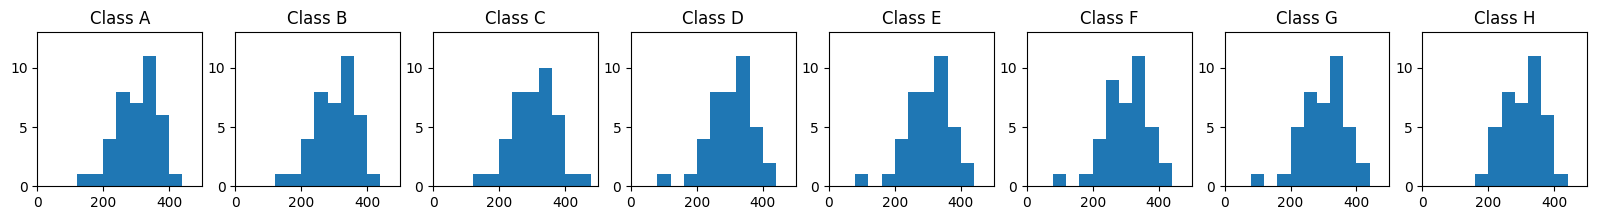

In [16]:
# 最適化前の分布
plt.figure(figsize=(20, 2))
for i, c in enumerate(students_df2['init_class'].sort_values().unique()):
    cls_df = students_df2[students_df2['init_class'] == c]
    plt.subplot(1, 8, i+1)
    plt.hist(cls_df['score'], bins=range(0, 500, 40))
    plt.xlim(0, 500)
    plt.ylim(0, 13)
    plt.title(f'Class {c}')

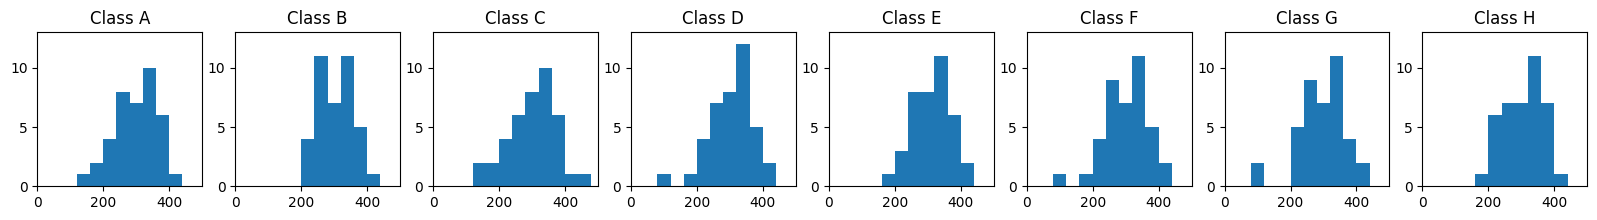

In [17]:
# score の分布
plt.figure(figsize=(20, 2))
for i, c in enumerate(result_df['class'].sort_values().unique()):
    cls_df = result_df[result_df['class'] == c]
    plt.subplot(1, 8, i+1)
    plt.hist(cls_df['score'], bins=range(0, 500, 40))
    plt.xlim(0, 500)
    plt.ylim(0, 13)
    plt.title(f'Class {c}')


In [18]:
result_df

,id,gender,leader,support,score,rank,init_class,class,flag,variable,score*var,flag*var,result
0,1,0,0,0,335,109.0,F,F,True,x001F,{x001F: 335},{x001F: 1},1.0
1,2,1,0,0,379,38.0,G,G,True,x002G,{x002G: 379},{x002G: 1},1.0
2,3,0,0,0,350,79.0,H,H,True,x003H,{x003H: 350},{x003H: 1},1.0
3,4,0,0,0,301,172.0,E,E,True,x004E,{x004E: 301},{x004E: 1},1.0
4,5,1,0,0,317,147.0,D,D,True,x005D,{x005D: 317},{x005D: 1},1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,314,0,0,0,244,263.0,H,G,False,x314G,{x314G: 244},{},1.0
314,315,1,0,0,309,162.0,C,C,True,x315C,{x315C: 309},{x315C: 1},1.0
315,316,0,0,0,239,272.0,A,A,True,x316A,{x316A: 239},{x316A: 1},1.0
316,317,1,0,0,356,63.0,H,H,True,x317H,{x317H: 356},{x317H: 1},1.0
